In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import matplotlib.patches as mpatches

In [2]:
class PedDataset(Dataset):
    def __init__(self, path, transforms=None, train=True):
        self.path = path
        self.transforms = transforms
        self.images = sorted([x for x in os.listdir(self.path + 'PNGImages')])
        self.masks = sorted([x for x in os.listdir(self.path + 'PedMasks')])
        self.annotations = sorted([x for x in os.listdir(self.path + 'Annotation')])
        if train:
            self.images = self.images[:int(len(self.images)*0.8)]
            self.masks = self.masks[:int(len(self.masks)*0.8)]
            self.annotations = self.annotations[:int(len(self.annotations)*0.8)]
        else:
            self.images = self.images[int(len(self.images)*0.8):]
            self.masks = self.masks[int(len(self.masks)*0.8):]
            self.annotations = self.annotations[int(len(self.annotations)*0.8):]
        
    def __len__(self):
        return len(self.images)
    
    @staticmethod
    def extract_bb(annot):
        boxes = []
        with open(annot, 'r') as f:
            for line in f:
                if 'Image size' in line:
                    size = re.findall(r'\d+', line)
                    h = int(size[0])
                    w = int(size[1])
                if '(Xmin, Ymin) - (Xmax, Ymax)' in line:
                    coords = re.findall(r'\d+', line)[1:]
                    coords = list(map(int, coords))
                    boxes.append(coords)
        return boxes
    
    def __getitem__(self, idx):
        img = T.ToTensor()(Image.open(self.path + 'PNGImages/' + self.images[idx]).convert('RGB'))
        masks = T.PILToTensor()(Image.open(self.path + 'PedMasks/' + self.masks[idx]))
        num_persons = masks.max()
        m = torch.zeros((num_persons, masks.shape[1], masks.shape[2]))
        for i in range(1, num_persons+1):
            m[i-1] = (masks == i).int()
        boxes = self.extract_bb(self.path + 'Annotation/' + self.annotations[idx])
        
        labels = torch.ones((num_persons,) , dtype = torch.int64)
        
        target = {}
        target['boxes'] = torch.FloatTensor(boxes)
        target['labels'] = labels
        target['masks'] = m
        
        return img, target

In [3]:
path = '/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/'
train_dataset = PedDataset(path)
val_dataset = PedDataset(path, train=False)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: list(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: list(zip(*x)))

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.9MB/s]


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model.to(device);

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [9]:
n_epochs = 15
history = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    print('-' * 10)
    total_loss = 0
    val_loss = 0
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        history.append(losses.cpu().data.numpy())
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        
    print(f"Train loss: {total_loss / len(train_loader)}")
    

Epoch 1/15
----------
Train loss: 1.2227726315750795
Epoch 2/15
----------
Train loss: 0.6736052465789458
Epoch 3/15
----------
Train loss: 0.5467819913345224
Epoch 4/15
----------
Train loss: 0.47973990177406983
Epoch 5/15
----------
Train loss: 0.4247499257326126
Epoch 6/15
----------
Train loss: 0.39991067437564626
Epoch 7/15
----------
Train loss: 0.38111980785341826
Epoch 8/15
----------
Train loss: 0.37288230131654176
Epoch 9/15
----------
Train loss: 0.35299287736415863
Epoch 10/15
----------
Train loss: 0.33690394724116607
Epoch 11/15
----------
Train loss: 0.31431910614756975
Epoch 12/15
----------
Train loss: 0.3146314204615705
Epoch 13/15
----------
Train loss: 0.2982441603260882
Epoch 14/15
----------
Train loss: 0.2917413584449712
Epoch 15/15
----------
Train loss: 0.27606990495148825


In [10]:
def show_image(img, result):
    c = 0
    for res in result['scores']:
        if res > 0.8:
            c += 1
    fig, ax = plt.subplots(1)
    ax.axis('off')
    ax.imshow(img.permute(1, 2, 0))
    for i in range(c):
        color = np.random.random(3)
        bb = result['boxes'][i].detach().cpu()
        mask = result['masks'][i].detach().cpu().numpy()[0]
#         print(mask.shape)
        coords = np.argwhere(mask>0.30)
        for idx, coord in enumerate(coords):
            coords[idx][0], coords[idx][1] = coord[1], coord[0] 
        polygon = mpatches.Polygon(coords, linewidth=1, edgecolor=color, facecolor='none', alpha=0.5)
        ax.add_patch(polygon)
        mpatch = mpatches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], edgecolor=color, facecolor="none",lw=2)
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()
        score = result['scores'][i].item()
        ax.annotate(f'{score:.2f}', (rx, ry-5), color=color, fontsize=10, ha='left', va='baseline')
    fig.show()

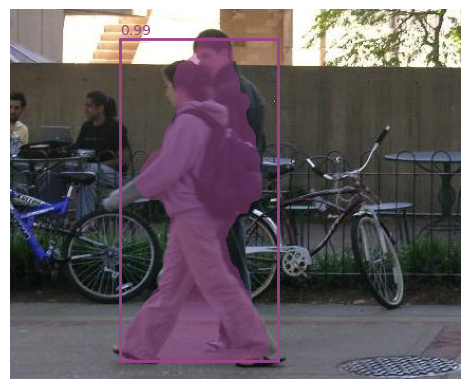

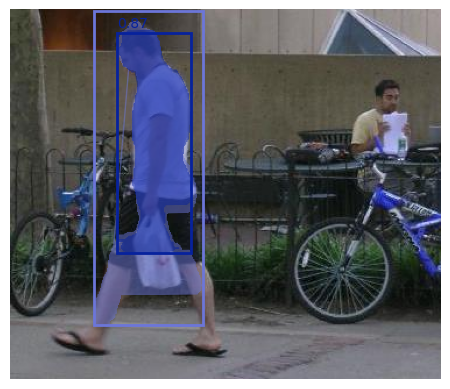

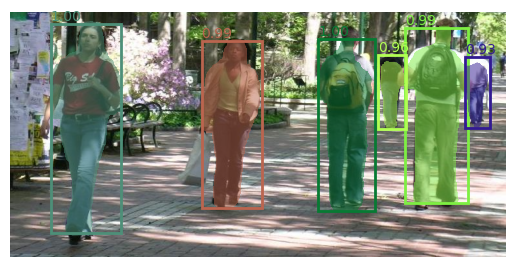

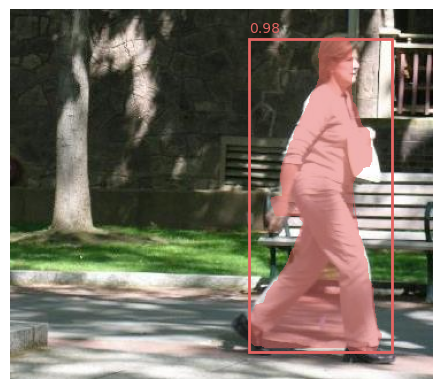

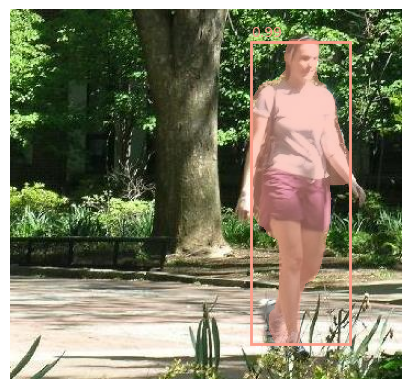

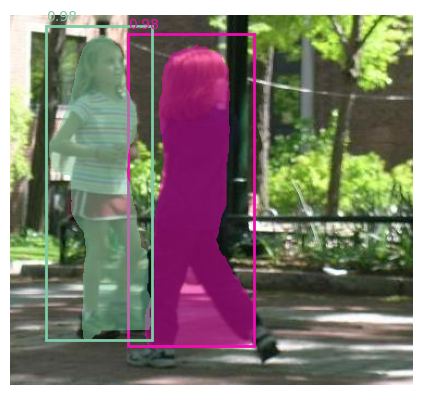

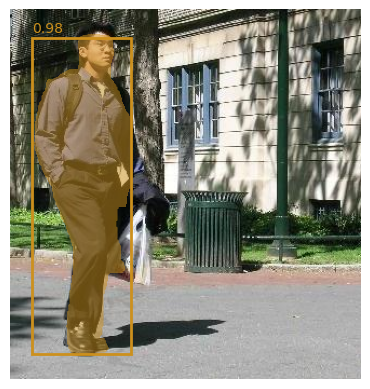

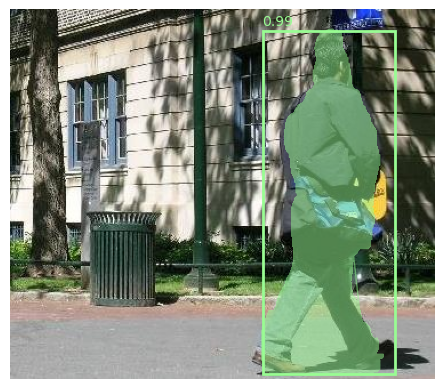

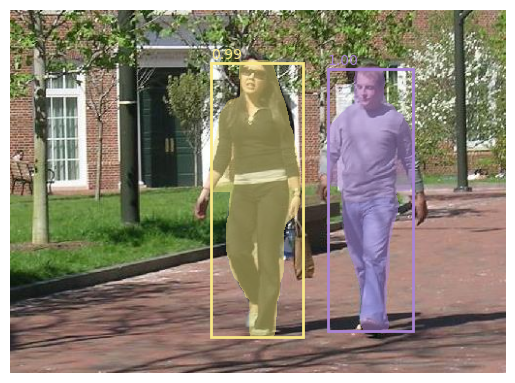

In [13]:
for images, _ in val_loader:
    model.eval()
    with torch.no_grad():
        images = [img.to(device) for img in images]
        results = model(images)
        image = images[0].detach().cpu()
    show_image(image, results[0])   

In [14]:
torch.save(model.state_dict(), 'model_weights.pth')